In [2]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

abbreviation key

gp = games played

net_rating = offRating - defRating

offRating = 100*((points)/POSS)

defRating = 100*((opp points/(opp POSS)))

oreb_pct = offensive rebound percentage

usg_pct = usage percentage is a measurement of the percentage of team plays utilized by a player while they are in the game

ts_pct = true shooting percentage.  percentage of shots made factoring in threes and free throws.  

ast_ptg = assist percentage.  Percent of field goals (2 or 3 point shots not including free throws) 





In [3]:
#!wget https://github.com/morganjng/nba-classifier/blob/main/all_seasons.csv
csv = pd.read_csv("all_seasons.csv")

In [25]:
total_players = len(csv["player_name"])
print(csv.columns, total_players)
for col in csv.columns:
    print(csv[col][0])

Index(['Unnamed: 0', 'player_name', 'team_abbreviation', 'age',
       'player_height', 'player_weight', 'college', 'country', 'draft_year',
       'draft_round', 'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object') 11700
0
Travis Knight
LAL
22.0
213.36
106.59412
Connecticut
USA
1996
1
29
71
4.8
4.5
0.5
6.2
0.127
0.182
0.142
0.536
0.052
1996-97


In [5]:
colleges = []
countries = []
years = []
seasons = []
teams = []
for i in range(0, total_players):
  if(csv["college"][i] not in colleges):
    colleges.append(csv["college"][i])
  if(csv["country"][i] not in countries):
    countries.append(csv["country"][i])
  if(csv["draft_year"][i] not in colleges):
    years.append(csv["draft_year"][i])
  if(csv["season"][i] not in seasons):
    seasons.append(csv["season"][i])
  if(csv["team_abbreviation"][i] not in teams):
    teams.append(csv["team_abbreviation"][i])
print(colleges, countries, years, seasons, teams)

['Connecticut', 'North Carolina-Wilmington', 'Iowa', 'Providence', 'None', 'Seward County Community College', 'Old Dominion', 'Temple', 'Georgia Tech', "St. John's (NY)", 'Washington State', 'Texas Tech', 'Seton Hall', 'American International', 'Massachusetts', 'Murray State', 'Drexel', 'Louisiana State', 'Long Beach State', 'New Mexico', 'Michigan', 'Pennsylvania', 'Michigan State', 'Missouri', 'Louisville', 'Georgetown', 'Louisiana Tech', 'Arkansas', 'Virginia', 'Cincinnati', 'Illinois', 'North Carolina State', 'Montevallo', 'Stetson', 'Wake Forest', 'West Florida', 'Notre Dame', 'UCLA', 'Kansas State', 'George Washington', 'North Carolina', 'Xavier', 'Wisconsin', 'Georgia Southern', 'San Diego State', 'Oklahoma', 'Memphis', 'Mt. San Antonio', 'Alabama', 'Arizona', 'Richmond', 'Syracuse', 'Gonzaga', 'Oklahoma State', 'Detroit Mercy', 'Arkansas-Little Rock', 'Maryland', 'McNeese State', 'Southern Mississippi', 'Purdue', 'Virginia Tech', 'Marquette', 'Ohio State', 'Georgia', 'La Salle'

In [6]:
sum_round = 0
count_round = 0
sum_number = 0
count_number = 0
for i in range(0, total_players):
  if(csv["draft_number"][i] != "Undrafted"):
    sum_number += int(csv["draft_number"][i])
    count_number += 1
  if(csv["draft_round"][i] != "Undrafted"):
    sum_round += int(csv["draft_round"][i])
    count_round += 1

mean_round = sum_round / count_round
mean_number = sum_number / count_number
print(mean_round, mean_number)

1.3026233603997501 21.783007080383175


In [8]:
for i in range(0, total_players):
  if(csv["draft_number"][i] == "Undrafted"):
    csv["draft_number"][i] = mean_number
  if(csv["draft_round"][i] == "Undrafted"):
    csv["draft_round"][i] = mean_round

In [9]:
def one_hot(value, array):
  v = [0 for i in range(len(array))]
  v[array.index(value)] = 1
  return torch.Tensor(v)

Data Preprocessing

In [42]:
def random_split(test_percent):
  test_amount = int(total_players * test_percent)
  test_sample = random.sample(range(0,total_players), test_amount)
  train_sample = [i for i in range(0, total_players)]
  test_x = []
  test_y = []
  train_x = []
  train_y = []
  for idx in test_sample:
    train_sample.remove(idx)
    test_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
    test_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
  for idx in train_sample:
    train_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
    train_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
  return train_x, train_y, test_x, test_y

In [43]:
%time train_x, train_y, test_x, test_y = random_split(0.2)

CPU times: user 9.69 s, sys: 159 ms, total: 9.85 s
Wall time: 9.79 s


In [44]:
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

9360 9360
2340 2340


Training

In [126]:
def train(neural_net, optimizer, loss, train_features, train_labels, epochs, batch_size, dropout=False):
  xs = [[] for i in range(epochs)]
  ys = [[] for i in range(epochs)]
  if(dropout):
    neural_net.train()
  for epoch in range(epochs):
    count = 0
    rl = 0.0
    optimizer.zero_grad()
    for i in range(len(train_labels)):
      train_y = train_labels[i]
      train_x = train_features[i]
      output = neural_net(train_x)
      out_loss = loss(output, train_y)
      out_loss.backward()
      optimizer.step()
      count += 1
      rl += out_loss.item()
      if count % batch_size == 0:
        optimizer.zero_grad()
        print(str(count) + " completed. Loss: " + str(rl/batch_size))
        xs[epoch].append(count)
        ys[epoch].append(rl/batch_size)
        rl = 0.0
  return xs, ys

In [127]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.teamLin = nn.Linear(len(teams), 1)
    self.collegeLin = nn.Linear(len(colleges), 1)
    self.countryLin = nn.Linear(len(countries), 1)
    self.draftLin = nn.Linear(len(years), 1)
    self.seasonLin = nn.Linear(len(seasons), 1)
    self.sequential = nn.Sequential(
        nn.Linear(13, 20),
        #nn.Dropout(p=0.2),
        nn.Linear(20, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 20),
        #nn.Dropout(p=0.2),
        nn.Linear(20, 7),
    )

  def forward(self, x):
    x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
    return self.sequential(x)

In [128]:
class LinearNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.teamLin = nn.Linear(len(teams), 1)
    self.collegeLin = nn.Linear(len(colleges), 1)
    self.countryLin = nn.Linear(len(countries), 1)
    self.draftLin = nn.Linear(len(years), 1)
    self.seasonLin = nn.Linear(len(seasons), 1)
    self.sequential = nn.Sequential(
        nn.Linear(13, 7)
    )

  def forward(self, x):
    x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
    return self.sequential(x)

In [129]:
neural = NeuralNet()
linnet = LinearNet()
loss = nn.MSELoss()
lin_optim = optim.Adam(linnet.parameters())
optimizer = optim.Adam(neural.parameters())

In [130]:
xs, ys = train(linnet, lin_optim, loss, train_x, train_y, 30, 200)

200 completed. Loss: 387.8629958629608
400 completed. Loss: 387.5451091384888
600 completed. Loss: 463.421806678772
800 completed. Loss: 448.7673196029663
1000 completed. Loss: 331.2195421791077
1200 completed. Loss: 356.9461658668518
1400 completed. Loss: 419.5395546722412
1600 completed. Loss: 550.5518789672851
1800 completed. Loss: 389.01133838653567
2000 completed. Loss: 289.88866995811463
2200 completed. Loss: 226.89266113758086
2400 completed. Loss: 301.2261417913437
2600 completed. Loss: 562.281332321167
2800 completed. Loss: 497.9941522216797
3000 completed. Loss: 425.7183196258545
3200 completed. Loss: 215.9421202468872
3400 completed. Loss: 198.79821778297423
3600 completed. Loss: 274.3641562080383
3800 completed. Loss: 417.8849127960205
4000 completed. Loss: 391.0440877532959
4200 completed. Loss: 480.7576388549805
4400 completed. Loss: 253.1668282032013
4600 completed. Loss: 283.5703982925415
4800 completed. Loss: 328.98094465255735
5000 completed. Loss: 375.86446517944336


4400 completed. Loss: 311.6191957092285
4600 completed. Loss: 542.5369216537475
4800 completed. Loss: 359.81674312591554
5000 completed. Loss: 386.3586810588837
5200 completed. Loss: 505.38301277160645
5400 completed. Loss: 597.2728482055664
5600 completed. Loss: 336.4523568344116
5800 completed. Loss: 327.33420476913454
6000 completed. Loss: 367.29402130126954
6200 completed. Loss: 586.2592196273804
6400 completed. Loss: 118.41130724430084
6600 completed. Loss: 119.50985019445419
6800 completed. Loss: 200.46832040548324
7000 completed. Loss: 210.0380487728119
7200 completed. Loss: 335.788883934021
7400 completed. Loss: 564.7858248901367
7600 completed. Loss: 519.4999226379394
7800 completed. Loss: 302.43510902404785
8000 completed. Loss: 289.4310819149017
8200 completed. Loss: 297.27329555511477
8400 completed. Loss: 331.12350185394286
8600 completed. Loss: 456.17583251953124
8800 completed. Loss: 515.971047821045
9000 completed. Loss: 595.9549562454224
9200 completed. Loss: 215.88953

8600 completed. Loss: 411.7195378112793
8800 completed. Loss: 201.2909311270714
9000 completed. Loss: 223.0479654121399
9200 completed. Loss: 332.10732833862306
200 completed. Loss: 181.61051869869232
400 completed. Loss: 258.8033045005798
600 completed. Loss: 379.1916583442688
800 completed. Loss: 288.88148376464846
1000 completed. Loss: 249.02928731918334
1200 completed. Loss: 432.4958041381836
1400 completed. Loss: 545.9236366271973
1600 completed. Loss: 467.8317790603638
1800 completed. Loss: 455.75738683700564
2000 completed. Loss: 474.76720076859
2200 completed. Loss: 423.17938683807847
2400 completed. Loss: 319.4102792990208
2600 completed. Loss: 258.5910216021538
2800 completed. Loss: 303.79381326675417
3000 completed. Loss: 580.14796875
3200 completed. Loss: 378.3172650909424
3400 completed. Loss: 410.7484988975525
3600 completed. Loss: 268.02287849426267
3800 completed. Loss: 411.2520862579346
4000 completed. Loss: 368.55487657546996
4200 completed. Loss: 124.02521525084973
4

3600 completed. Loss: 445.3736524963379
3800 completed. Loss: 320.59519807815553
4000 completed. Loss: 131.00116779327394
4200 completed. Loss: 125.86809516072273
4400 completed. Loss: 173.31301579236984
4600 completed. Loss: 229.93992645531893
4800 completed. Loss: 282.73893957734106
5000 completed. Loss: 339.99988629698754
5200 completed. Loss: 359.57376607894895
5400 completed. Loss: 371.66972222328184
5600 completed. Loss: 382.6957033920288
5800 completed. Loss: 506.4585520935059
6000 completed. Loss: 750.6547905731201
6200 completed. Loss: 561.4249662017822
6400 completed. Loss: 394.9105311203003
6600 completed. Loss: 140.30666945457457
6800 completed. Loss: 116.65123569488526
7000 completed. Loss: 133.62755323410033
7200 completed. Loss: 148.594306589365
7400 completed. Loss: 186.00192475266755
7600 completed. Loss: 217.5688593262434
7800 completed. Loss: 238.52014980792998
8000 completed. Loss: 265.6317203903198
8200 completed. Loss: 291.2214296007156
8400 completed. Loss: 419.7

7400 completed. Loss: 532.4508712768554
7600 completed. Loss: 506.2997311401367
7800 completed. Loss: 243.86866302251815
8000 completed. Loss: 263.8271291255951
8200 completed. Loss: 269.88723284721374
8400 completed. Loss: 355.1779735183716
8600 completed. Loss: 487.7857558822632
8800 completed. Loss: 454.72290756225584
9000 completed. Loss: 283.73298334121705
9200 completed. Loss: 311.76454650878907
200 completed. Loss: 88.73644495487213
400 completed. Loss: 88.74628349304199
600 completed. Loss: 186.9516808319092
800 completed. Loss: 351.51359802246094
1000 completed. Loss: 175.13340609550477
1200 completed. Loss: 292.95085346221924
1400 completed. Loss: 488.76607822418214
1600 completed. Loss: 439.9601403427124
1800 completed. Loss: 614.4775218200683
2000 completed. Loss: 572.7549216461182
2200 completed. Loss: 480.8694490146637
2400 completed. Loss: 348.93663768351075
2600 completed. Loss: 299.6226497268677
2800 completed. Loss: 385.6551174926758
3000 completed. Loss: 778.01613613

2200 completed. Loss: 610.9597231292724
2400 completed. Loss: 637.5434387207031
2600 completed. Loss: 298.332833404541
2800 completed. Loss: 197.31721977233886
3000 completed. Loss: 230.91887258529664
3200 completed. Loss: 453.1710036468506
3400 completed. Loss: 274.17270511627197
3600 completed. Loss: 141.45696755409242
3800 completed. Loss: 102.48607708930969
4000 completed. Loss: 118.40912635564804
4200 completed. Loss: 154.05389873504637
4400 completed. Loss: 231.26726263046265
4600 completed. Loss: 374.86117599487307
4800 completed. Loss: 553.6544165039063
5000 completed. Loss: 362.7168471002579
5200 completed. Loss: 445.61717988967894
5400 completed. Loss: 581.8552560424805
5600 completed. Loss: 320.38379565238955
5800 completed. Loss: 328.1779466819763
6000 completed. Loss: 461.84977867126463
6200 completed. Loss: 506.46354701995847
6400 completed. Loss: 384.44040687561034
6600 completed. Loss: 222.18230810165406
6800 completed. Loss: 174.5725454902649
7000 completed. Loss: 241.

6200 completed. Loss: 336.31516639709474
6400 completed. Loss: 468.19644256591795
6600 completed. Loss: 645.8322338867188
6800 completed. Loss: 442.6158600997925
7000 completed. Loss: 226.6385494041443
7200 completed. Loss: 245.61089744567872
7400 completed. Loss: 332.2278144836426
7600 completed. Loss: 262.26961812973025
7800 completed. Loss: 249.92891238689424
8000 completed. Loss: 260.4686746716499
8200 completed. Loss: 260.97859765172007
8400 completed. Loss: 235.69161655664445
8600 completed. Loss: 245.0864381313324
8800 completed. Loss: 307.0887476348877
9000 completed. Loss: 248.21344745635986
9200 completed. Loss: 227.82956851959227
200 completed. Loss: 135.8861400270462
400 completed. Loss: 321.4560957336426
600 completed. Loss: 468.5461932373047
800 completed. Loss: 521.4196954917908
1000 completed. Loss: 145.7272281265259
1200 completed. Loss: 192.19409929513932
1400 completed. Loss: 276.50272097587583
1600 completed. Loss: 376.0341465449333
1800 completed. Loss: 450.7854117

tensor([-7589.4097,  1171.7825,   -51.0296,  1450.9220, -5637.3896, -1454.5673,
         3519.0479], grad_fn=<AddBackward0>)
tensor([7.9000, 1.8000, 0.8000, 0.0260, 0.0950, 0.5390, 0.0880])


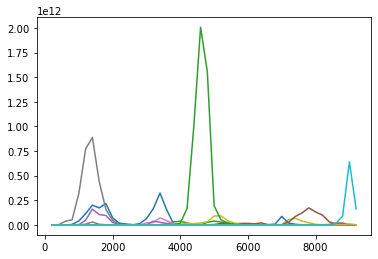

In [115]:
for i in range(len(xs)):
    plt.plot(xs[i], ys[i])
print(neural(test_x[1]))
print(test_y[1])

K-fold validation

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.semilogy(range(1, num_epochs + 1), train_ls)
            plt.semilogy(range(1, num_epochs + 1), valid_ls)
            plt.legend(['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k